# Identify significant differences between model and ERA5 AR regime anomalies

* Input: `/glade/work/mkorendy/metisregimes/data.AR.10%.PNA.NDJFM.k5.composite.nc`
* Input: `/glade/work/mkorendy/metisregimes/data.AR.10%.PNA.NDJFM.k5.clustering.nc`

1. Take the difference between the composites (means)

3. Calculate the significance of the differences

4. Plot composite of mean difference with significance in hatching

* Output: `era_vs_metis199.AR.10%.PNA.NDJFM.k5.diff_anoms.png`

## Imports

In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from scipy.stats import ttest_ind

## Files

In [2]:
path = '/glade/work/mkorendy/metisregimes/'

f_era_comp = path + 'era5.AR.10%.PNA.NDJFM.k5.composite.nc'
f_metis_comp = path + 'metis199.AR.10%.PNA.NDJFM.k5.composite.nc'

f_era_raw = path + 'era5.AR.10%.PNA.NDJFM.k5.clustering.nc'
f_metis_raw = path + 'metis199.AR.10%.PNA.NDJFM.k5.clustering.nc'

f_out = 'era5_vs_metis199.AR.10%.PNA.NDJFM.k5.diff_anoms.png'

## Read in data

In [3]:
# Means
ds_era_comp = xr.open_dataset(f_era_comp)
ds_metis_comp = xr.open_dataset(f_metis_comp)

# Raw data
ds_era_raw = xr.open_dataset(f_era_raw)
ds_metis_raw = xr.open_dataset(f_metis_raw)

## Identify the clusters
Use highest correlation with regimes for metis199 identification

In [28]:
era_regimes = ['Pacific Wavetrain', 'Arctic Low', 'Pacific Trough', 'Arctic High', 'Alaskan Ridge']
metis_regimes = ['Pacific Trough', 'Pacific Wavetrain', 'Arctic High', 'Arctic Low', 'Alaskan Ridge']

ds_era_comp = ds_era_comp.assign_coords(cluster=era_regimes)
ds_metis_comp = ds_metis_comp.assign_coords(cluster=metis_regimes)

In [31]:
#Identify for raw data by iterating through the clusters, replacing with 

ls_era_raw = []
for clust in ds_era_raw.cluster.values:
    ls_era_raw.append(era_regimes[clust])

ls_metis_raw = []
for clust in ds_metis_raw.cluster.values:
    ls_metis_raw.append(metis_regimes[clust])

In [32]:
ds_era_raw = ds_era_raw.assign_coords(cluster=ls_era_raw)
ds_metis_raw = ds_metis_raw.assign_coords(cluster=ls_metis_raw)

## Take the difference in the composites for each cluster

In [6]:
ds_diff = ds_era_comp - ds_metis_comp

## Significance of the difference

### State the problem
Where is the mean difference different enough to be considered significant (meaning its unlikely it happened by random chance)?

$\mu_x$ = ERA5 Composite ($n_x$ = 8160)

$\mu_y$ = Metis199 Composite ($n_y$ = 204000)

### Define our Null Hypothesis

Null Hypothesis (H0): Differences between the two means is zero

$\mu_x-\mu_y=0$

### Pick a level of significance

In [7]:
p = .1

### Use the stats `ttest_ind` function
Iterate through each cluster's raw data to get the pvalue
Then mask the difference data using the pvalue

In [59]:
ls_mask = []

for k in np.arange(0,5):
    era_clust = ds_era_raw.sel(cluster = era_regimes[k]).drop('time')
    metis_clust = ds_metis_raw.sel(cluster = era_regimes[k])

    tstat, pval = ttest_ind(era_clust.river_anoms,metis_clust.river_anoms,equal_var=False)
    
    mask = ds_diff.river_anoms[k].where(pval < p)
    
    ls_mask.append(mask)

/glade/u/home/mkorendy/miniconda3/envs/wxregimes/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [72]:
da_mask = xr.DataArray(ls_mask, coords={'cluster':ds_diff.cluster,'lat':ds_diff.lat,
                                       'lon':ds_diff.lon}, dims=['cluster','lat','lon'])

## Plot the masked difference

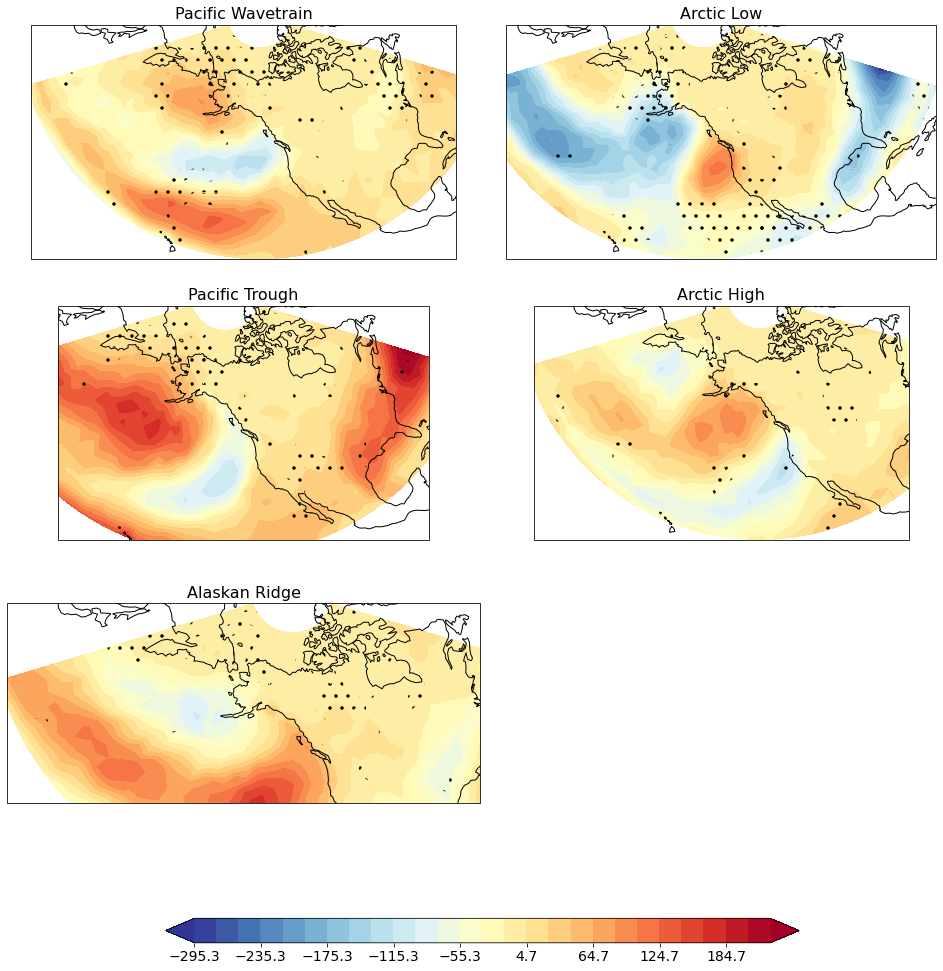

In [86]:
cm = 225
minlon = -70 + cm
maxlon = 80 + cm

clevs = np.arange(min(ds_diff.river_anoms.values.flatten()), max(ds_diff.river_anoms.values.flatten()),20)

data_crs = ccrs.PlateCarree(central_longitude=cm)
proj = ccrs.NorthPolarStereo(central_longitude=cm)
#proj = ccrs.PlateCarree(central_longitude=cm)
fig,axs=plt.subplots(3,2,subplot_kw={'projection':proj},figsize=(22,17))

for i,ax in enumerate(axs.flatten()):
    #ax.set_extent(extent)
    if (i < 5):
        cs=ax.contourf(ds_diff['lon'],ds_diff['lat'],
                       ds_diff.river_anoms[i] + 1e-100,clevs,
                       transform=ccrs.PlateCarree(),
                       cmap='RdYlBu_r', extend='both')
        cs2=ax.contourf(ds_diff['lon'],ds_diff['lat'],
                   da_mask[i] + 1e-100,[0,1],colors='None',
                   transform=ccrs.PlateCarree(),hatches=['.',''],extend='both',alpha=0)
        ax.clabel(cs2,fmt='%2d')
        ax.set_title(era_regimes[i],fontdict={'fontsize':16})
        #ax.gridlines()
        ax.coastlines()
fig.delaxes(axs.flatten()[5])

fig.subplots_adjust(bottom=0.3, top=0.95, left=0.2, right=0.8,
                    wspace=0.01, hspace=0.2)
cbar_ax = fig.add_axes([0.3, 0.2, 0.4, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(labelsize=14) 